In [1]:
import pandas as pd 
import sys
import torch
from torch.utils.data import TensorDataset, DataLoader
import time 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../../duq/')  
import post, pre
import mc_dropout as MC

import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppresses sklearn warning about PCA.. Is this ok?

Device =  cpu


In [2]:
seed = 1234                  # Assign a value to the seed
pre.set_seed(seed)      # Set the seed for 'random', 'np.random', 'torch.manual_seed' and 'torch.cuda.manual_seed_all'

# Importing Data

## Import, Pre-process and Split Data

## Splitting Test Set from Main Corpus

This code imports the full dataset in `csv` format for analysis. 

The user can choose which frequency to predict by changing `y_cols` here. More than one frequency can be in this list, however some of the plotting functions need to be changed slightly. See `MC_Dropout_multi_output.ipynb` for an example of predicting multiple frequencies. 

The column headings (and corresponding indices) are as follows:

| num_x | num_y | num_z | width_x | width_y | width_z | freq1 | freq2 | freq3 | freq4 | freq5 | freq6 |
| :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- |
| [0] | [1] | [2] | [3] | [4] | [5] | [6] | [7] | [8] | [9] | [10] | [11] |

In [3]:
y_cols = [6]             # Which column(s) does the the dependent variable(s) that we're interested in sit? list
x_cols = [0,1,2,3,4,5]   # Which column(s) is the independent variable(s) (features) in? list
component = "n/a"        # this is used if we want to sort and split the data by a particular parameter

# Import the csv file and save as DataFrame
filepath = '../../data/all_data.csv'
df_orig = pd.read_csv(filepath, header=None)
df_orig.columns = ['nbays_x', 'nbays_y', 'nbays_z', 'bay_width_x', 'bay_width_y', 'bay_width_z', 'modal_freq_1', 'modal_freq_2', 'modal_freq_3', 'modal_freq_4', 'modal_freq_5', 'modal_freq_6']

# Calculate the mean and standard deviation of the original dataset
data_mean = df_orig.mean()
data_std = df_orig.std()

# Visualise full dataset in reduced dimensional space 
_, components = post.PCA_transformdata(df_orig.iloc[:,x_cols], return_components=True)

## Split Data into Test, Train, Val

len(x_train): 1975
len(x_test): 2
len(x_val): 1


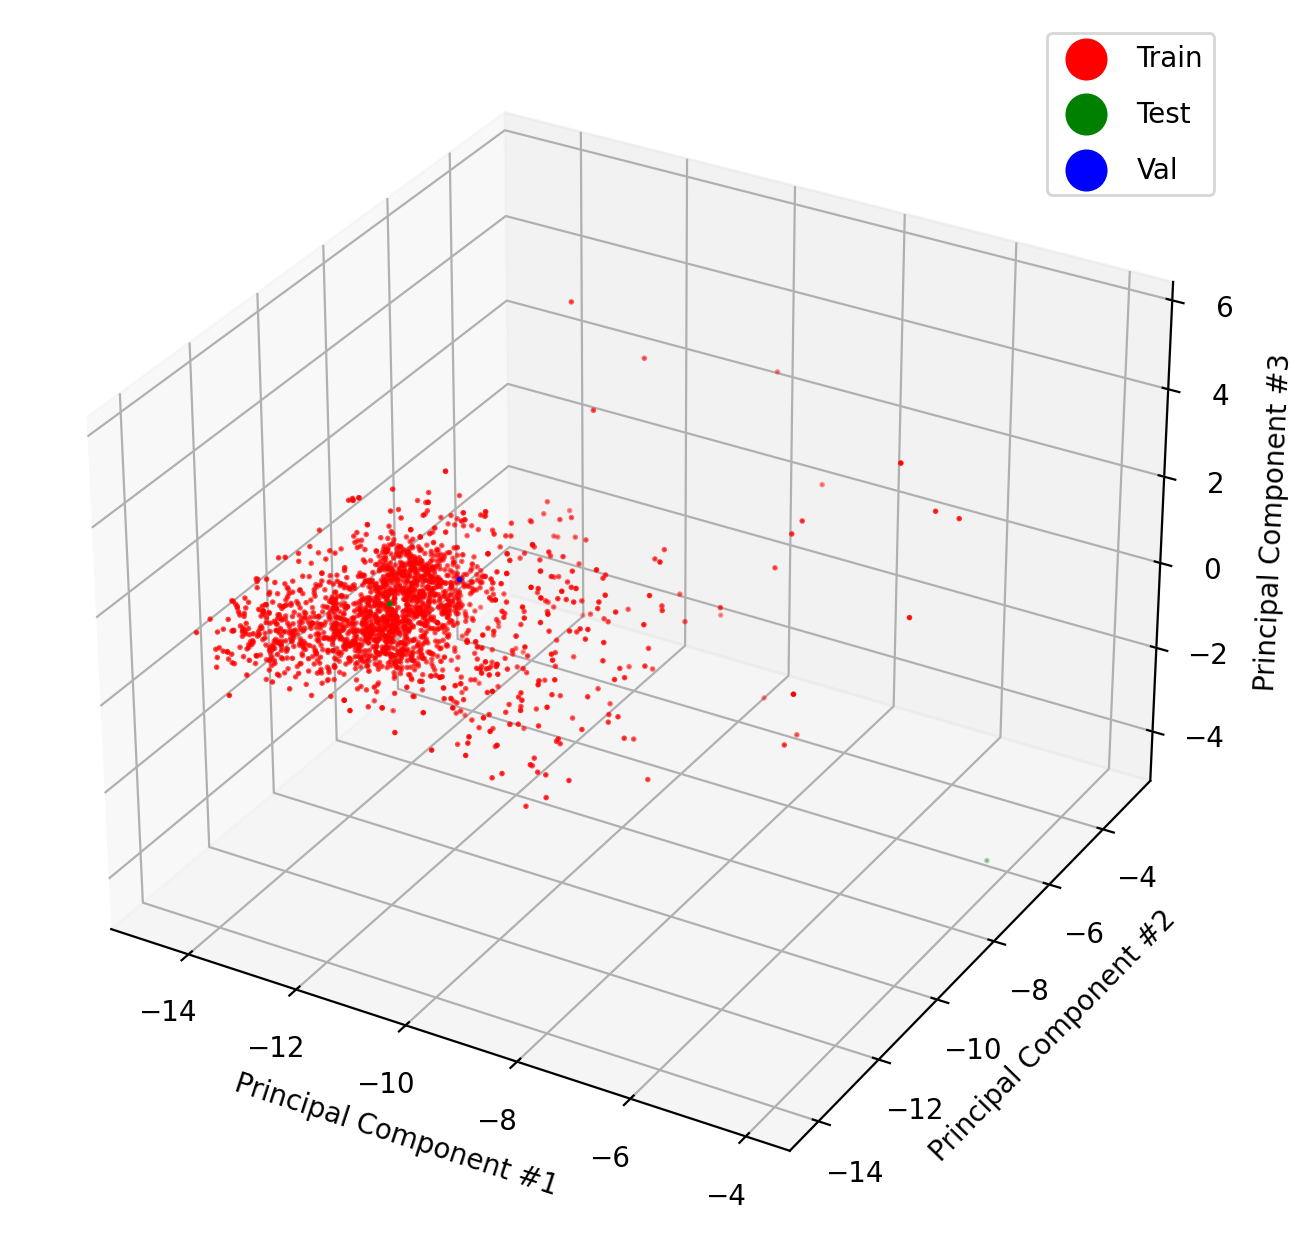

In [4]:
# Add a new column for L2 distance from Eulicidean mean and normalise. Return the original mean and sigma
df_1, data_mean_1, data_std_1 = pre.process_df_euclid(df=df_orig.copy(), x_cols=x_cols)

component = 12           # Which column to sort by? This affects the splitting of validation data and visualisation later on
cutoff_percentile = (0.000005,0.000005)#0.2775 # How much to cut off the beginning and end of sorted dataset
val_split = 0.000005          # How much to split off for validation (after the OoD/test data has been split off from train)

# Split training, testing and validation data
TRAIN, VAL, TEST = pre.split_data(df_1, component=component, y_cols=y_cols, x_cols=x_cols, cutoff_percentile=cutoff_percentile, val_split=val_split, seed=seed)
x_train, y_train, train_data, train_indices = TRAIN
x_val, y_val, val_data, val_indices = VAL
x_test, y_test, test_data, test_indices = TEST

print(f"len(x_train): {len(x_train)}")
print(f"len(x_test): {len(x_test)}")
print(f"len(x_val): {len(x_val)}")

# Get PCA of NORMALISED data, but according to UNNORMALISED PCA components
x_train_PCA = post.PCA_transformdata(x_train, components=components)
x_test_PCA = post.PCA_transformdata(x_test, components=components)
x_val_PCA = post.PCA_transformdata(x_val, components=components)

post.PCA_plot([x_train_PCA, x_test_PCA, x_val_PCA], labels=["Train", "Test", "Val"], legend_num=0, figsize=(8,8),dpi=200)

y_train_unnorm = pre.unnormalise(y_train,data_mean[y_cols].values,data_std[y_cols].values)
y_val_unnorm = pre.unnormalise(y_val,data_mean[y_cols].values,data_std[y_cols].values)
y_test_unnorm = pre.unnormalise(y_test,data_mean[y_cols].values,data_std[y_cols].values)


## Run quick stats on datasets

These histograms show the distribution of y values (i.e. frequency) in the split datasets. 

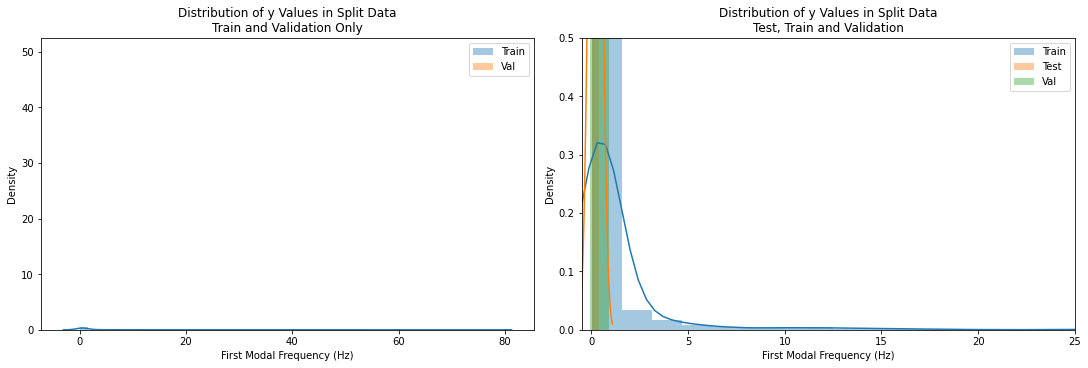

In [5]:
fig, axs = plt.subplots(1,2,constrained_layout=True, figsize=(15,5))

sns.distplot(y_train_unnorm,bins=50,label="Train",ax=axs[0])
sns.distplot(y_val_unnorm,bins=50,label="Val",ax=axs[0])
axs[0].set_title("Distribution of y Values in Split Data\nTrain and Validation Only")
axs[0].set_xlabel("First Modal Frequency (Hz)")
axs[0].legend()

sns.distplot(y_train_unnorm,label="Train",ax=axs[1])
sns.distplot(y_test_unnorm,label="Test",ax=axs[1])
sns.distplot(y_val_unnorm,label="Val",ax=axs[1])
axs[1].set_title("Distribution of y Values in Split Data\nTest, Train and Validation")
axs[1].set_xlabel("First Modal Frequency (Hz)")
axs[1].set_ylim((0,0.5))
axs[1].set_xlim((-0.5,25))
axs[1].legend();

# Neural Network Instantiation and Training

## Define Parameters of the Model

In [23]:
# Save the model so we can load it and perform inference later
savename = "../../trained_models/for_prediction/MCDropout_reference"
#checkpoint_path = "../trained_models/for_retraining/MC_Dropout"

parameters = dict(
    # Specific to this method
    drop_prob=0.0,
    num_samples=1,
    
    # Generic Hyperparameters
    num_epochs= 5000,
    batch_size= 50,              # Batch size for training data
    lr=  1e-5,                   # Learning rate
    weight_decay= None,          # Weight decay
    
    # Model architecture
    input_dim= len(x_cols),      # Number of input neurons
    output_dim= len(y_cols),     # Number of output neurons
    num_units= 200,              # Number of neurons per hidden layer
    num_layers=5,
    
    # Data
    y_cols = y_cols,             # Which column(s) contain the dependent variable(s) / label(s) 
    x_cols = x_cols,             # Which column(s) contain the independent variable(s) / feature(s)
    
    # Logigng only
    component = None,            # Which parameter are we sorting by (as an int)? 
    sortby=None,                 # Name of the component we're sorting by (as a string)
    model_name= "MC_Dropout_Reference",    # For logging only
    criterion_name= "MSELoss",   # For logging only
    optimiser_name= "Adam",      # For logging only 
    cutoff_percentile = None,    # How much we're splitting from top and bottom of sorted training set for test set 
    val_split=None,              # How much we're splitting from the train set (minus the test set), as a float between 0-1
    seed=seed,                   # Random seed used (for logging only)
    ood_lims_in=None,     # Inner OOD limits
    train_lims_all=None, # Training set limits
    ood_lims_out=None    # Outer OOD limits
)

assert parameters['output_dim'] == len(y_cols), f"Please ensure that the number of output neurons is correct! There should be {len(y_cols)}"
assert parameters['input_dim'] == len(x_cols), f"Please ensure that the number of input neurons is correct! There should be {len(x_cols)}" 

## If using Weights and Biases API, Log In

In [7]:
# Whether or not to log the run to Weights and Biases (https://wandb.ai/home). Requires an account
wandb_mode = False

if wandb_mode: 
    import wandb
    wandb.login()
    wandb.init(config=parameters, entity="archieluxton", project=parameters['model_name'])

## Instantiate the Model Class

In [8]:
# Instantiate a model class of type MC Dropout
model = MC.MC_Dropout(train_data = train_data,
                              parameters=parameters, 
                              val_data=val_data,
                              data_mean=data_mean,
                              data_std=data_std,
                              wandb_mode=wandb_mode)

## Train the Model

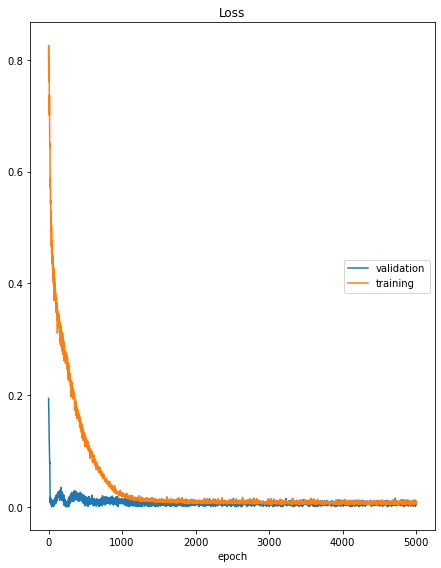

Loss
	validation       	 (min:    0.000, max:    0.194, cur:    0.008)
	training         	 (min:    0.004, max:    0.826, cur:    0.006)
Time elapsed: 818.45s.
Number of trainable model parameters: 122201, number of training samples: 1975
Used batches of 50.

Time taken: 818.4759991168976s


In [9]:
start = time.time()

net, train_loss, val_loss = model.train_model()

end = time.time()
print(f"Time taken: {end-start}s")

In [ ]:
num_samples = 150
x_value = np.array([5, 5, 5, 10, 10, 10])

s, m, sd = model.make_prediction(x_value = x_value,
                          model = model,
                          data_mean = data_mean,
                          data_std = data_std,
                          verbose=False,            # Optional, default=False
                          plots=False,              # Optional, default=False
                          num_samples=num_samples)  # Optional, default = 100

print(f"Using X = {x_value}, modal frequency = {m.item():.3f} Hz, +/- {sd.item():.3f} Hz (+/-{100*sd.item()/m.item():.2f}%)")

# Save Model State

In [24]:
#torch.save(model, savename)